In [49]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import ipympl

inputs = np.load('inputs.npy')
labels = np.load('labels.npy')
#inputs = np.load('inputs_small.npy', allow_pickle=True)
#labels = np.load('labels_small.npy', allow_pickle=True)
print(inputs.shape,labels.shape)
print(type(inputs),type(labels))

# Convert the input array to a PyTorch tensor
inputs = torch.tensor(inputs, dtype=torch.float32)

# Convert the labels to a PyTorch tensor
labels = torch.tensor(labels, dtype=torch.long)

(94477, 468) (94477,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [50]:
#!pip install scikit-learn

In [51]:
from sklearn.model_selection import train_test_split

inputs_train, inputs_test, labels_train, labels_test = train_test_split(inputs, 
                                                    labels, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(inputs_train), len(inputs_test), len(labels_train), len(labels_test)
print(inputs_train.shape)

torch.Size([75581, 468])


In [52]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y     

    def __len__(self):
        return len(self.X,)

    def __getitem__(self, idx):
        return self.X[idx],self.Y[idx]
train_data = CustomDataset(inputs_train,labels_train)
test_data = CustomDataset(inputs_test,labels_test)
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [53]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f9fd0668eb0>, <torch.utils.data.dataloader.DataLoader object at 0x7fa00403e9d0>)
Length of train dataloader: 2362 batches of 32
Length of test dataloader: 591 batches of 32


In [54]:
# Define the number of features in the input data
n_features = inputs.shape[1]

# Define the number of classes to classify the data into
n_classes = 250

# Define the neural network architecture
class NeuralNet(nn.Module):
    def __init__(self,n_features=3258, n_classes=250):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


class NeuralNet(nn.Module):
    def __init__(self, n_features=3258, n_classes=250, dropout_rate=0.2):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.softmax(self.fc4(x))
        return x   


In [55]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [56]:
# Create an instance of the neural network
model = NeuralNet(n_features=n_features, n_classes=n_classes,dropout_rate=0.2)

In [57]:
def train_step(model,dataloader,loss_fn,optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [58]:
def test_step(model,dataloader,loss_fn):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [59]:
# 1. Take in various parameters required for training and test steps
def train(model,train_dataloader, 
          test_dataloader, optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        if epoch % 5 == 4: 
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

Epoch: 5 | train_loss: 5.3654 | train_acc: 0.1663 | test_loss: 5.3366 | test_acc: 0.1957
Epoch: 10 | train_loss: 5.3285 | train_acc: 0.2017 | test_loss: 5.3083 | test_acc: 0.2218
Epoch: 15 | train_loss: 5.3050 | train_acc: 0.2253 | test_loss: 5.2813 | test_acc: 0.2478
Epoch: 20 | train_loss: 5.2910 | train_acc: 0.2389 | test_loss: 5.2694 | test_acc: 0.2606
Epoch: 25 | train_loss: 5.2812 | train_acc: 0.2482 | test_loss: 5.2676 | test_acc: 0.2615
Epoch: 30 | train_loss: 5.2732 | train_acc: 0.2559 | test_loss: 5.2544 | test_acc: 0.2754
Epoch: 35 | train_loss: 5.2683 | train_acc: 0.2611 | test_loss: 5.2496 | test_acc: 0.2798
Epoch: 40 | train_loss: 5.2620 | train_acc: 0.2674 | test_loss: 5.2462 | test_acc: 0.2829
Epoch: 45 | train_loss: 5.2573 | train_acc: 0.2716 | test_loss: 5.2351 | test_acc: 0.2933
Epoch: 50 | train_loss: 5.2537 | train_acc: 0.2750 | test_loss: 5.2342 | test_acc: 0.2946
Epoch: 55 | train_loss: 5.2512 | train_acc: 0.2775 | test_loss: 5.2315 | test_acc: 0.2976
Epoch: 60 |

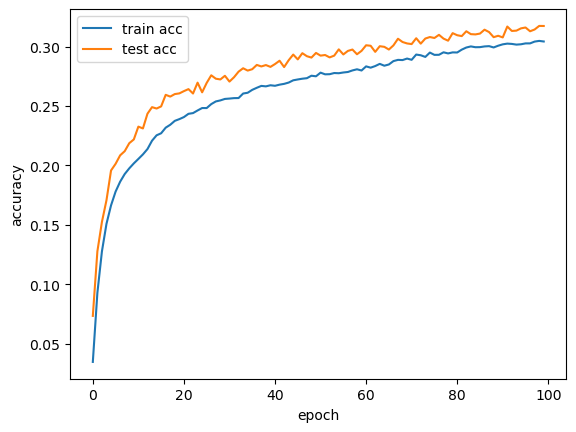

In [60]:
%matplotlib inline
# Set number of epochs
NUM_EPOCHS = 100

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plt.figure()
plt.plot(model_results['train_acc'],label='train acc')
plt.plot(model_results['test_acc'],label='test acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()